# Deep Taylor Decomposition and Geometric Saliency 


## Importing and the network:

See Tutorial 01

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz
INFO:tensorflow:Restoring parameters from ./Models/MLP
Prediction is: 4


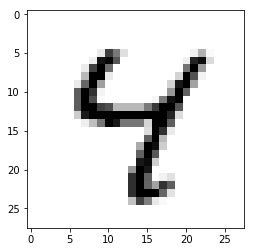

In [1]:
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
import Mnist_net as mn
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

data = input_data.read_data_sets('data/MNIST/', one_hot=True)
structure =np.array([[400,0,1,1],[200,0,1,1],[100,0,1,1],[50,0,1,1]])
netsize = len(structure) # this variable is useful to have 

net = mn.network()
net.setup(load = "./Models/MLP",structure=structure,end_relu = True,end_biases = True, data = data,offset = -0.5)
#net.optimize(8000)
#net.save("./Models/MLP")

im=data.test.images[6]
prediction = net.give_class(im)
print("Prediction is: %d"%prediction)
net.plot_image(im)

## Deep Taylor

The complete form of the Deep taylor algorithm is given below:

In [2]:
def Deep_Taylor(net,im, prediction = None,suppress_out = False):
    """
    net: a mnist_net object
    im: a image to analyse
    prediction: if None the entire output array is back propagated, if it has a value (0-9) then only that class' relevance will be propagated
    suppress_out: if False the relevance of the last layer is displayed as an image, if true it will supress this.
    
    returns: rel: an array of the relevance in each layer
    """
    #get the output before the softmax
    rel = [net.give_prob(im,len(net.structure))[0]]
    if prediction is not None:
        #this allows the relevance of only a single element to propagate this takes into account the maxpool decision criteria.
        mask = np.zeros(net.give_prob(im,len(net.structure))[0].shape)
        mask[prediction] = 1
        rel[0] = np.multiply(rel[0],mask)
    
    # here we get an array of the number of elements in each layer, not just the user created layers.
    full_structure = [28*28] #image size
    for i in range(0,net.structure.shape[0]):
        full_structure.append(net.structure[i][0]) #hidden nodes
    full_structure.append(10) #output layer
    
    #for each layer
    for layer in range(4,-1,-1):
        #choose z plus or z beta rule
        if layer>0:
            weights = net.session.run(net.weights[layer])*(net.session.run(net.weights[layer])>0)
        else:
            weights = net.session.run(net.weights[layer])

        layer_rel = np.zeros(full_structure[layer])
        for i in range(0,full_structure[layer]):
            
            #choose z plus or z beta rule
            if layer>0:
                x =net.give_prob(im,layer-1)[0]
                sum_z =(x.dot(weights))
            else:
                x = im-net.offset
                sum_z =x.dot(weights)+np.sum(-(net.offset*weights*(weights>0))-((1+net.offset)*weights*(weights<0)),axis=0)

            #perform the summation
            temp = 0
            for j in range(0,full_structure[layer+1]):
                #choose z plus or z beta rule
                if layer>0:
                    z = (x[i]*weights[i][j])
                else:
                    z = x[i]*weights[i][j]+(-net.offset*weights[i][j]*(weights[i][j]>0))-((1+net.offset)*weights[i][j]*(weights[i][j]<0))

                temp = temp +  z /sum_z[j] * rel[-1][j]
            #keep track of the layer element relevances
            layer_rel[i] = temp
        #keep track of the layer relevances
        rel.append(layer_rel)
    #plot output
    if not suppress_out:
        net.plot_image(rel[-1])
    
    #returns the whole array of relevances for each layer
    return rel

We can test the algorithm on images like this:

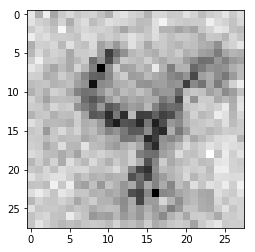

Wall time: 22.6 s


In [3]:
%%time
#choose an image
im=data.test.images[6]
#run the network
rel = Deep_Taylor(net,im)

If the we are concerned with only one output and not the whole output array we can use the "prediction" parameter. It doesn't make much difference:

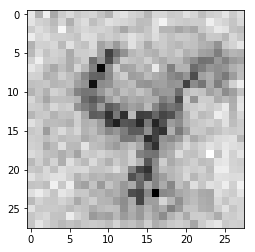

In [4]:
rel = Deep_Taylor(net,im,prediction = 8)

If we wish to show the conservation of relevance:

In [5]:
#show conservation of relevance
for i in range(0,len(rel)-1):
    print(np.sum(rel[i]))

4.049797058105469
4.049797381253388
4.049797300774421
4.049797421972114
4.049797440308675


One alternative way of showing the relevance is to multiply the original image by the produced value (note we use the ofset image here):

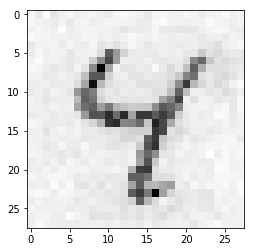

In [6]:
#plot the scaled image 
net.plot_image(np.multiply(rel[-1],im-net.offset))

An alternative way is to use different colour chanels

(mask has had it's contrast boosted)


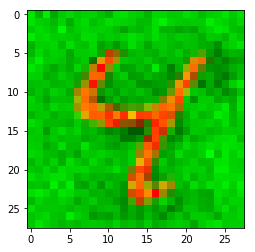

In [7]:
mask = rel[-1]
#first boost the mask contrast
temp=1-mask
temp = temp-min(temp)
temp = np.divide(temp,max(temp))
#then stack the image onto the red channel and the mask onto the green:

masked = np.stack([im.reshape(28,28),temp.reshape(28,28),np.zeros([28,28])],axis= 2)
plt.imshow(masked)
print("(mask has had it's contrast boosted)")

In this image the areas which are strongly red have a much higher pixel value than relevance value, areas which are strongly green have a highter relevance than pixel value

For similar results we can choose to plot the difference between the relevanece and the image:

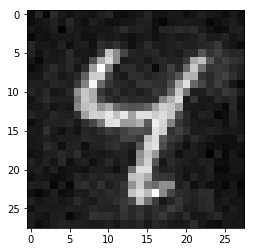

In [8]:
net.plot_image(temp-im)

## Geometric Saliency

Firstly, any image can be chosen, and we will investigate different methods of obtaining the difference between two outputs:

[4, 8]


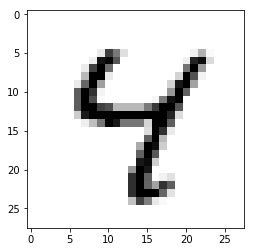

In [9]:
im=data.test.images[6]
Prediction=np.argmax(net.give_prob(im,netsize)) #most popular
Comparison = net.give_prob(im,netsize).argsort()[0][-2:][0] #-2 is second most popular

print([Prediction,Comparison])
net.plot_image(im)

The prediction class is the class with the highest score, here we will be comparing it to the class with the second highest score. The difference (before softmax) is calculated by combining the weight and bias vectors of the chosen classes. The cell below additionally demonstrates how ReLUs can be changed into matrices. and the same result is found using an if statement in each layer as when using the input specific matrices. 

In [10]:
#running the network, vs single calculation
w0 = net.session.run(net.weights[0]).copy()
b0 = net.session.run(net.biases[0]).copy()

w1 = net.session.run(net.weights[1]).copy()
b1 = net.session.run(net.biases[1]).copy()

w2 = net.session.run(net.weights[2]).copy()
b2 = net.session.run(net.biases[2]).copy()

w3 = net.session.run(net.weights[3]).copy()
b3 = net.session.run(net.biases[3]).copy()

wt= net.session.run(net.weights[4]).copy()
bt= net.session.run(net.biases[4]).copy()

#we onlt care about two outputs:
w4=(wt[:,Prediction]-wt[:,Comparison]).copy()
b4=(bt[Prediction]-bt[Comparison]).copy()

x0 = im.flatten()+net.offset

x1 = x0.dot(w0)+b0
r1 = (1.0*(x1>=0))
R1 = np.diag(r1)

x2 = x1.dot(R1).dot(w1)+b1
r2 = (1.0*(x2>=0))
R2 = np.diag(r2)

x3 = x2.dot(R2).dot(w2)+b2
r3 = (1*(x3>=0))
R3 = np.diag(r3)

x4 = x3.dot(R3).dot(w3)+b3
r4 = (1*(x4>=0))
R4 = np.diag(r4)

y = x4.dot(R4).dot(w4)+b4

W = w0.dot(R1).dot(w1).dot(R2).dot(w2).dot(R3).dot(w3).dot(R4).dot(w4)
B = (((b0.dot(R1).dot(w1)+b1).dot(R2).dot(w2)+b2).dot(R3).dot(w3)+b3).dot(R4).dot(w4)+b4

print("network       vs   calculation")
print(y,x0.dot(W)+B)

network       vs   calculation
8.698944076736419 8.698946100183111


The same result is obtained when using the network on it's own, showing the code is consistient and that the maths is valid:

In [11]:
#using the network
probs = net.give_prob(im,netsize)[0]
print('difference is:')
print(probs[Prediction]-probs[Comparison])

difference is:
8.698943


Simply analysing W in isolation can form the basis of a saliency method, although it doesn't make a lot of sense:

[4, 8]
12.74874 4.049797


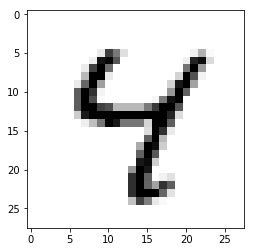

[ 0.          0.5651914   0.          0.         12.74874     0.
  0.11342414  0.          4.049797    0.7439949 ]


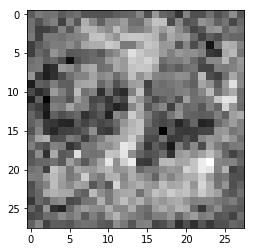

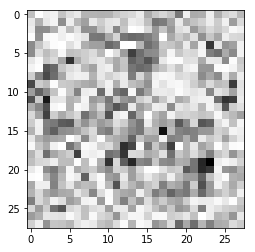

In [12]:
im=data.test.images[6]

Prediction=np.argmax(net.give_prob(im,netsize)) #most popular
Comparison = net.give_prob(im,netsize).argsort()[0][-2:][0] #-2 is second most popular

probs = net.give_prob(im,netsize)[0]
print([Prediction,Comparison])
print(probs[Prediction],probs[Comparison])
net.plot_image(im)
print(probs)

W,B,y=net.find_plane(im,node=[Prediction,Comparison])
net.plot_image(W)
net.plot_image(abs(W))

This functionality has been built into Mnist_net and can be called as net.find_plane. when called it returns W,B and y for any node or pair of nodes. When a pair is used y = the difference in outputs.  


Now we can implement the core Geometric saliency algorithm, it can be used for finding an approximation of the closest point to a given input on a decision plane. The decision plane can be for a single output or for the boundary between two outputs.

In [19]:
def GeoSal(net,x,Prediction = None, Comparison = None,bounds = [None,None],layer=None, suppress_out = False):
    """
    Prediction: When Comparison is None this performs a variation of Deep fool, finding the closest image which outputs prediction class ~ 0
    Comparison: when comparison has a value this finds the closest point which has the difference between Prediction classs and Comparison class ~ 0
    Bounds: The output image will be forced between the bounds, 
    layer:  The output can focus on a specific layer other than the last (None defaults to last)
    suppress_out: prevents printing of messages about convergence time
    
    Returns: guess,W,B,y
    Guess is the new image, close to the original with outpu/difference of outputs very close to zero
    W is the weight matrix which is identical to running guess through the network
    B is the bias vector which is identical to running guess through the network
    y is the remaining error (difference from zero)
    
    If there is no convergence all outputs will be None. For apropriate inputs this should always converge. 
    """
    
    
    if Comparison is not None:   
        node = [Prediction, Comparison]
    else:
        node = Prediction
    
    factor = 1*10**-14 #this ensures the point ends up on the other side of the boundary 

    ##get the plane
    guess= x.flatten()
    W,B,y = net.find_plane(guess,node=node,layer=layer)
    
    if Prediction == Comparison:
        return guess,W,B,y
    
    inity = y
    guesses = [-1]
    prevb= B
    prevw = W
    prevguess =[-1]
    Found = False
    converge = False
    
    i=0
    while i<100:
        
        if len(guesses)>2: #this means we have hit the border twice in a row, now we look for the converging solution
            
            if not suppress_out:
                print('converged to edge in: ',i)
            
            #find the converging solution an infinite geometric progression
            with np.errstate(invalid='ignore'): #ignore divide by zero warning, it's handled by nan_to_num
                delta1 = guesses[-2]-guesses[-3]
                delta2 = guesses[-1]-guesses[-2]

                r = np.nan_to_num(np.divide(delta2,delta1))

                guess = guesses[-3]+np.nan_to_num(np.divide(delta1,1-r)) 
        
                #force within bounds (just in case)
                if bounds[0] is not None:
                    guess=guess-bounds[0]
                    guess=guess*(guess>0)
                    guess=guess+bounds[0]

                if bounds[1] is not None:
                    guess=guess-bounds[1]
                    guess=guess*(guess<0)
                    guess=guess+bounds[1]
                
                guesses = [-1]
                W,B,y=net.find_plane(guess,node = node,layer=layer) 

                

        
        else:
            dist = (B+guess.dot(W))/(W.dot(W))
            guess= guess - np.multiply(W,dist+factor)
                        
            #force within bounds
            if bounds[0] is not None:
                guess=guess-bounds[0]
                guess=guess*(guess>0)
                guess=guess+bounds[0]

            if bounds[1] is not None:
                guess=guess-bounds[1]
                guess=guess*(guess<0)
                guess=guess+bounds[1]

            W,B,y=net.find_plane(guess,node = node,layer=layer)


            #the same plane multiple times means we are at the bounds - might get a converging solution
            if ((B == prevb).all() and (W == prevw).all()):
                if (guess == prevguess).all():
                    #this is due to floating point errors,when the error gets small
                    if not suppress_out:
                        print("stationary after", i)
                    while y>0:
                        guess =guess+(guess-x.flatten())*1.01*y/inity
                        if bounds[0] is not None:
                            guess=guess-bounds[0]
                            guess=guess*(guess>0)
                            guess=guess+bounds[0]

                        if bounds[1] is not None:
                            guess=guess-bounds[1]
                            guess=guess*(guess<0)
                            guess=guess+bounds[1]

                        W,B,y=net.find_plane(guess,node = node,layer=layer)
                else:
                    guesses.append(guess)
            else:
                guesses = [guess]

            prevb = B
            prevw = W
            prevguess = guess
        
        
        if (y<=0):
            Found = True
            if not suppress_out:
                print('found in: ',i)
            break
        
        i=i+1
    
    if Found == True:
        W,B,y=net.find_plane(guess,node = node,layer=layer)
        return guess,W,B,y

    else:
        if not suppress_out:
            print("Did not find")
        return guess,W,B,y

Look at a single example between a 4 and a 9, the difference is very hard to see in the first image, the second shows only the difference with increased contrast and the third shows the effect of adding 20 times the difference to the original image, to emphasise how the 4 becomes a 9.

converged to edge in:  3
stationary after 5
found in:  5
error is: [-0.14879219]


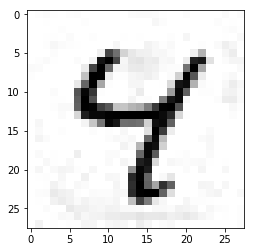

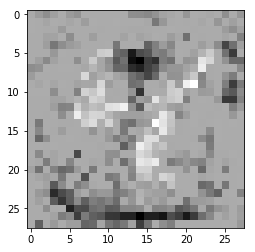

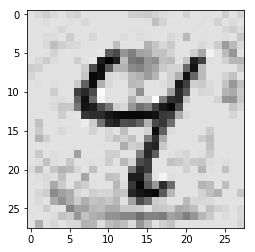

In [20]:
temp,W,B,y = GeoSal(net,im,4,9,bounds=[0,1])
print("error is:",y)
net.plot_image(temp)
net.plot_image(temp-im)
net.plot_image(im +5*(temp-im))

The GeoSal algorithm can be used in many ways, one of the simplest is the "weighted sum of changes" method, shown below

0 error is [-0.54849946]
1 error is [-7.1128365e-05]
2 error is [-1.2314267]
3 error is [-0.13429332]
4 error is [0.]
5 error is [-0.04720827]
6 error is [-1.0522552]
7 error is [-1.513149]
8 error is [-0.09535775]
9 error is [-0.14879219]

 Absolute Importance:


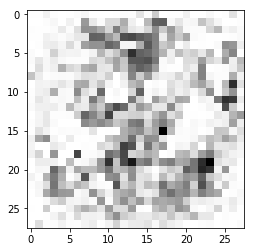

Directional Importance:


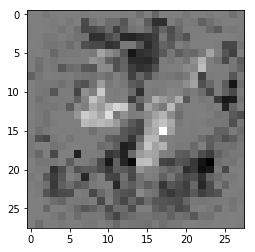

Wall time: 4.54 s


In [26]:
%%time
delta1 = 0*im.flatten() # create empty array
delta2 = 0*im.flatten() # create empty array

for Comparison in range(0,10):
    #get guess for each comparison
    border_image,W,B,y = GeoSal(net,im,Prediction, Comparison, bounds=[0,1],suppress_out = True)
    print(Comparison,"error is",y)
    #take the differences
    diff1 = abs(border_image-im.flatten())
    diff2 = (border_image-im.flatten())
    
    #add the weighted differnce to the output image
    delta1 = delta1+diff1*net.give_prob(im)[0][Comparison]
    delta2 = delta2+diff2*net.give_prob(im)[0][Comparison]

print("\n Absolute Importance:")
net.plot_image(delta1)

print("Directional Importance:")
net.plot_image(delta2)

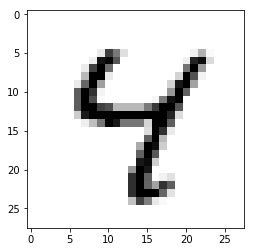

Absolute mask with contrast boosted


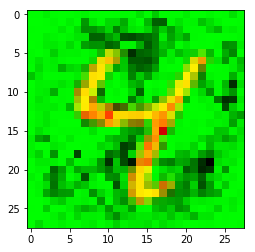

Directional mask with contrast boosted


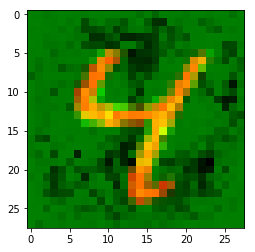

In [16]:
net.plot_image(im)

temp=1-delta1
temp = temp-min(temp)
temp = np.divide(temp,max(temp))

masked = np.stack([im.reshape(28,28),temp.reshape(28,28),np.zeros([28,28])],axis= 2)
plt.imshow(masked)
print("Absolute mask with contrast boosted")
plt.show()

temp=1-delta2
temp = temp-min(temp)
temp = np.divide(temp,max(temp))

masked = np.stack([im.reshape(28,28),temp.reshape(28,28),np.zeros([28,28])],axis= 2)
plt.imshow(masked)
print("Directional mask with contrast boosted")


found in:  1


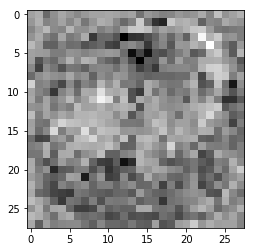

In [17]:
#Deep fool result:
border_image,W,B,y = GeoSal(net,im,Prediction,bounds=[0,1])
net.plot_image(np.multiply(W,im+net.offset-border_image))
